<a href="https://colab.research.google.com/github/inder-dev-pro/EDA-Mark_Keith/blob/main/Startup_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import kagglehub
import pandas as pd
import plotly.figure_factory as ffdemo
import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder
# Download latest version
path = kagglehub.dataset_download("yanmaksi/big-startup-secsees-fail-dataset-from-crunchbase")

In [31]:
print("Path to dataset files:", path)
df=pd.read_csv(path+ r"/big_startup_secsees_dataset.csv")
df.head(5)
print(df.nunique())
print(df['status'].value_counts())
df.dropna(subset='status', inplace=True)

Path to dataset files: /root/.cache/kagglehub/datasets/yanmaksi/big-startup-secsees-fail-dataset-from-crunchbase/versions/1
permalink            66368
name                 66102
homepage_url         61191
category_list        27296
funding_total_usd    18896
status                   4
country_code           137
state_code             311
region                1092
city                  5111
funding_rounds          19
founded_at            3978
first_funding_at      4817
last_funding_at       4518
dtype: int64
status
operating    53034
closed        6238
acquired      5549
ipo           1547
Name: count, dtype: int64


In [32]:
numerical_cols=df.select_dtypes(include=np.number).columns.to_list()
categorical_cols=df.select_dtypes(include=object).columns.to_list()
numerical_cols
categorical_cols
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
df['first_funding_at']=pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at']=pd.to_datetime(df['last_funding_at'], errors='coerce')
df['founded_at']=pd.to_datetime(df['founded_at'], errors='coerce')



```
# Dividing the data into Train, Test and Val
```



In [33]:
train_val_data, test_data=train_test_split(df,test_size=0.2, random_state=42)
train_data, val_data=train_test_split(train_val_data, test_size=0.25, random_state=42)
input_cols=['country_code', 'region', 'city', 'funding_total_usd', 'funding_rounds', 'first_funding_at', 'last_funding_at', 'founded_at']
target_cols=['status']
x_train=train_data[input_cols]
y_train=train_data[target_cols]

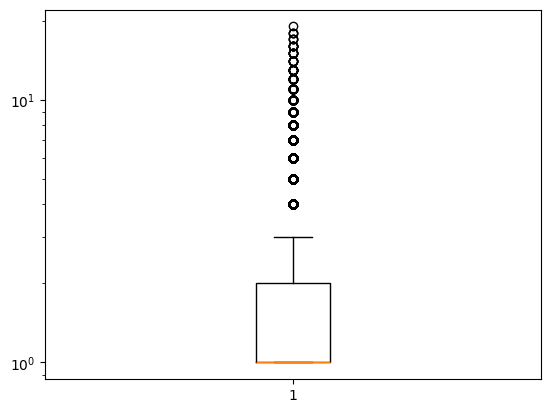

In [34]:
plt.boxplot(x=df['funding_rounds'])
plt.yscale('log')
plt.show()



```
Converting the status(Target col) into a Numeric Column
```



In [50]:
one_hot_encoding=OneHotEncoder()
one_hot_encoding.fit(df[['status']])
feature_names=one_hot_encoding.get_feature_names_out(['status'])
status_encoded=one_hot_encoding.transform(df[['status']]).toarray()
status_encoded_df=pd.DataFrame(status_encoded, columns=feature_names)
df=df.drop(axis=1, columns='status')
df=pd.concat([df,status_encoded_df], axis=1)
df.head(5)

,permalink,name,homepage_url,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,status_acquired,status_closed,status_ipo,status_operating
0,/organization/-fame,#fame,http://livfame.com,Media,10000000.0,IND,16,Mumbai,Mumbai,1,NaT,2015-01-05,2015-01-05,0.0,0.0,0.0,1.0
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000.0,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14,0.0,0.0,0.0,1.0
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878.0,NaN,NaN,NaN,NaN,1,NaT,2014-01-30,2014-01-30,0.0,0.0,0.0,1.0
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000.0,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19,0.0,0.0,0.0,1.0
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,NaN,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24,0.0,0.0,0.0,1.0


In [36]:
outlier=[]
def outlier_detection(data):
  threshold=4
  mean=np.mean(data)
  std=np.std(data)

  for i in data:
    if ((i-mean)/std>3):
      outlier.append(i)

  return outlier
out=outlier_detection(df.funding_rounds)

outlier_df_z=pd.DataFrame(out, columns=["Funding_Round_Outlier"])
outlier_df_z

,Funding_Round_Outlier
0,9
1,6
2,9
3,7
4,6
...,...
1725,8
1726,6
1727,8
1728,7


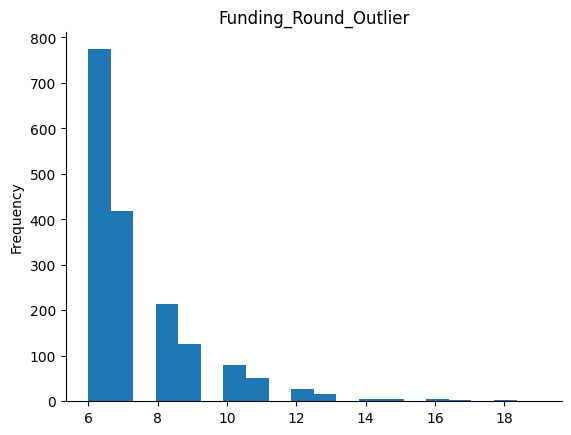

In [37]:
from matplotlib import pyplot as plt
outlier_df_z['Funding_Round_Outlier'].plot(kind='hist', bins=20, title='Funding_Round_Outlier')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [38]:
iqr_outlier_list=[]
def IQR(data):
  q1,q3=np.percentile(data,[25,75])
  iqr=q3-q1
  lower_bound=q1-((iqr)*1.5)
  upper_bound=q3+((iqr)*1.5)
  for i in data:
    if (i<lower_bound or i>upper_bound):
      iqr_outlier_list.append(i)
  return iqr_outlier_list
iqr_out=IQR(df.funding_rounds)

outlier_df_iqr=pd.DataFrame(iqr_out,columns=["Outlier_using_IQR"])
outlier_df_iqr

,Outlier_using_IQR
0,4
1,4
2,9
3,5
4,6
...,...
5932,4
5933,4
5934,4
5935,4


In [40]:
from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='Outlier_using_IQR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

NameError: name '_df_2' is not defined

In [41]:
target_encoder=TargetEncoder(return_df=True,cols='country_code').fit(x_train,y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

In [51]:
print(df.first_funding_at)
df.nunique()
df.isnull().sum()
df.isna().sum()

0       2015-01-05
1       2014-03-01
2       2014-01-30
3       2008-03-19
4       2014-07-24
           ...    
66363   2012-04-01
66364   2011-11-01
66365   2014-08-01
66366   2015-01-01
66367   2013-10-01
Name: first_funding_at, Length: 66368, dtype: datetime64[ns]


,0
permalink,0
name,1
homepage_url,5058
category_list,3148
funding_total_usd,12785
country_code,6958
state_code,8547
region,8030
city,8028
funding_rounds,0


In [43]:
!git init
!git remote add origin https://github.com/inder-dev-pro/EDA-Mark_Keith.git
!git branch -m main
!git add .
!git status
!git commit -m "Initial Upload"
!git config --global user.email "inder.31ssb.com"
!git config --global user.name "inder-dev-pro"
!git push origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
On branch main

No commits yet

Changes to be committed:
  (use "git rm --cached <file>..." to unstage)
	new file:   .config/.last_opt_in_prompt.yaml
	new file:   .config/.last_survey_prompt.yaml
	new file:   .config/.last_update_check.json
	new file:   .config/active_config
	new file:   .config/config_sentinel
	new file:   .config/configurations/config_default
	new file:   .config/default_configs.db
	new file:   .config/gce
	new file:   .config/hidden_gcloud_